In [ ]:
# Rogue AP detection as Anomaly with SVM
# André L. S. Paula / Eduardo K. Viegas / Altair O. Santim

# SVM

# Import Modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM, SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, auc
from sklearn import utils
from google.colab import drive
import warnings
warnings.filterwarnings("ignore")
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Selection dataset / features
df_orig = pd.read_csv('/content/drive/MyDrive/datasets/dataset.csv')


In [ ]:
relevant_features = ['rogue', 'Dot11EltCountry', 'RSNVersion', 'rates',
       'CapabilitiesMin_MPDCU_Start_Spacing', 'DSSS_CCK', 'Max_A_MSDU',
       'Rx_STBC', 'Tx_STBC', 'Short_GI_40Mhz', 'Short_GI_20Mhz',
       'SM_Power_Save', 'Supported_Channel_Width', 'LDPC_Coding_Capability',
       'Min_MPDCU_Start_Spacing', 'Max_A_MPDU_Length_Exponent',
       'TX_MCS_Set_Defined', 'RX_MSC_Bitmask',
       'Compressed_Steering_n_Beamformer_Antennas_Supported', 'Receive_NDP',
       'entropy']

data = df_orig[relevant_features]
df_orig.shape

(357, 21)

In [ ]:
# Count RogueAP in dataset
data['rogue'].value_counts()

rogue
 1    186
-1    171
Name: count, dtype: int64

In [ ]:
# class 1 (normal): data['rogue'] == 1 ]
# class -1 (attack): data['rogue'] == -1 ]
target = data['rogue']

# Outliers
outliers = target[target == -1]
print("outliers.shape", outliers.shape)
print("outlier fraction", outliers.shape[0]/target.shape[0])

# Features without target (rogue)
data.drop(["rogue"], axis=1, inplace=True)

# check data shape
data.shape

outliers.shape (171,)
outlier fraction 0.4789915966386555


(357, 20)

In [ ]:
# Test and train dataset selection
from sklearn.model_selection import train_test_split
train_data, test_data, train_target, test_target = train_test_split(data, target, train_size = 0.8)
train_data.shape

(285, 20)

In [ ]:
nu = outliers.shape[0] / target.shape[0]
print("nu", nu)

nu 0.4789915966386555


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(train_data)

from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import SVC

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, train_target)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': 1.0, 'gamma': 0.1} with a score of 0.83


In [ ]:
# Applying SVM
model_SVM = SVC(C=1.0, gamma=1.0)
y_score_svm = model_SVM.fit(train_data, train_target)
y_pred_svm = model_SVM.decision_function(train_data)

In [ ]:
# Identifying the metrics from Train SVM
preds_SVM = model_SVM.predict(train_data)
targs_SVM = train_target

print("accuracy: ", metrics.accuracy_score(targs_SVM, preds_SVM))
print("precision: ", metrics.precision_score(targs_SVM, preds_SVM))
print("recall: ", metrics.recall_score(targs_SVM, preds_SVM))
print("f1: ", metrics.f1_score(targs_SVM, preds_SVM))
print("area under curve (auc): ", metrics.roc_auc_score(targs_SVM, preds_SVM))


accuracy:  0.9438596491228071
precision:  0.9473684210526315
recall:  0.9473684210526315
f1:  0.9473684210526315
area under curve (auc):  0.9436090225563909


[]

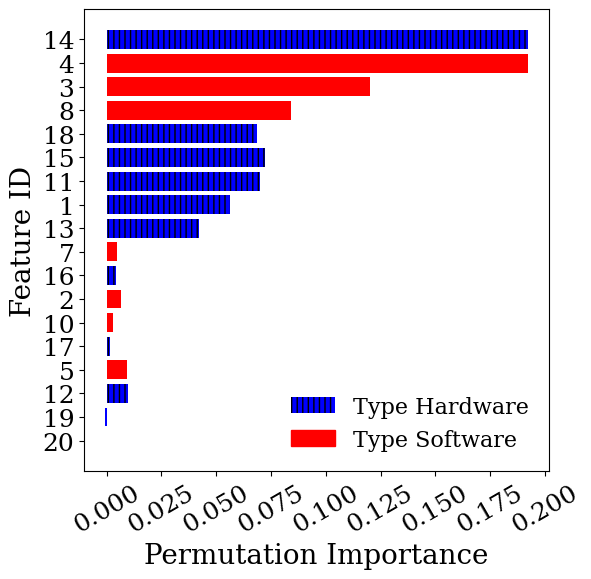

In [ ]:
# Ganho de informação SVM with RBF
%matplotlib inline
perm_importance = permutation_importance(model_SVM, train_data, train_target)

features = ['Dot11EltCountry', 'RSNVersion', 'rates',
       'CapabilitiesMin_MPDCU_Start_Spacing', 'Max_A_MSDU', 'Supported_Channel_Width', 'LDPC_Coding_Capability', 'Receive_NDP', 'entropy',
       'DSSS_CCK','Rx_STBC', 'Tx_STBC', 'Short_GI_40Mhz', 'Short_GI_20Mhz', 'SM_Power_Save', 'TX_MCS_Set_Defined', 'RX_MSC_Bitmask', 'Compressed_Steering_n_Beamformer_Antennas_Supported', 'Min_MPDCU_Start_Spacing', 'Max_A_MPDU_Length_Exponent']

feature_names = features = ['1', '2', '3','4', '5', '6','7', '8', '9', '10', '11', '12', '13','14', '15','16', '17','18', '19','20']
features = np.array(feature_names)
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(6,6), dpi=100)
#plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.barh(features[19], perm_importance.importances_mean[19],color = 'blue', hatch='|||')
plt.barh(features[18], perm_importance.importances_mean[18],color = 'blue', hatch='|||')
plt.barh(features[11], perm_importance.importances_mean[11],color = 'blue', hatch='|||')
plt.barh(features[4], perm_importance.importances_mean[4],color = 'red')
plt.barh(features[16], perm_importance.importances_mean[16],color = 'blue', hatch='|||')
plt.barh(features[9], perm_importance.importances_mean[9],color = 'red')
plt.barh(features[1], perm_importance.importances_mean[1],color = 'red')
plt.barh(features[15], perm_importance.importances_mean[15],color = 'blue', hatch='|||')
plt.barh(features[6], perm_importance.importances_mean[6],color = 'red')
plt.barh(features[12], perm_importance.importances_mean[12],color = 'blue', hatch='|||')
plt.barh(features[0], perm_importance.importances_mean[0],color = 'blue', hatch='|||')
plt.barh(features[10], perm_importance.importances_mean[10],color = 'blue', hatch='|||')
plt.barh(features[14], perm_importance.importances_mean[14],color = 'blue', hatch='|||')
plt.barh(features[17], perm_importance.importances_mean[17],color = 'blue', hatch='|||')
plt.barh(features[7], perm_importance.importances_mean[7],color = 'red')
plt.barh(features[2], perm_importance.importances_mean[2],color = 'red')
plt.barh(features[3], perm_importance.importances_mean[3],color = 'red')
plt.barh(features[13], perm_importance.importances_mean[13],color = 'blue', hatch='|||')
plt.legend(['Type Hardware','Type Software'],loc="lower right", fontsize=16,frameon=False)
plt.xlabel("Permutation Importance", size=20)
plt.ylabel("Feature ID", size=20)
ax = plt.gca()
leg = ax.get_legend()
#leg.legendHandles[0].set_color('blue')
leg.legendHandles[0].set_hatch('|||')
leg.legendHandles[1].set_color('red')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.yticks(size=18)
plt.xticks(size=18,rotation = 30)
plt.savefig("GAININFORMATION.pdf", format="pdf", bbox_inches="tight",)
plt.plot(style=['o', 'rx'])

Text(0, 0.5, '')

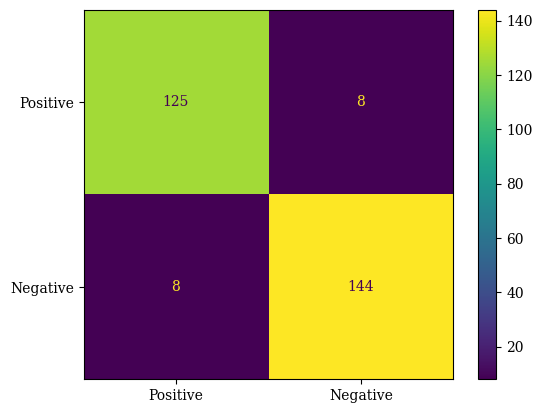

In [ ]:
# Confuion Matrix SVM
MatrizConfusao2 = confusion_matrix(targs_SVM,preds_SVM)
ConfusionMatrixDisplay(confusion_matrix(targs_SVM,preds_SVM),display_labels=['Positive','Negative']).plot()
plt.plot(title="SVM")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.xlabel('')
plt.ylabel('')

In [ ]:
# Visualization
#import matplotlib.pyplot as plt
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler
#from mlxtend.plotting import plot_decision_regions
#from mpl_toolkits.mplot3d import Axes3D
#pca = PCA(n_components=2)  # Reduce to k=2 dimensions
#scaler = StandardScaler()
#normalize the metrics
#X_reduce = pca.fit_transform(test_data)
#model_SVM.fit(X_reduce,test_target)
#plot_decision_regions(X_reduce,test_target.values, clf=model_SVM)
#plt.title('SVM Decision Region Boundary', size=16)
#plt.show()

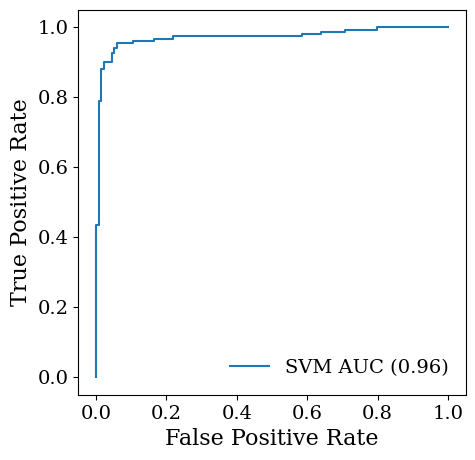

In [ ]:
from sklearn.metrics import roc_curve, auc

svm_fpr, svm_tpr, threshold = roc_curve(train_target, y_pred_svm)
auc_svm = auc(svm_fpr, svm_tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(svm_fpr, svm_tpr, linestyle='-', label='SVM (auc = %0.3f)' % auc_svm)
plt.xlabel('False Positive Rate', size=16)
plt.ylabel('True Positive Rate',size=16)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.legend(['SVM AUC (0.96)'],loc="lower right", markerscale=0.7, fontsize=14,frameon=False)
plt.yticks(size=14)
plt.xticks(size=14)
plt.savefig("ROCSVM.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# Applying SVM
# Identifying the metrics from Test (Predict)
preds_SVM = model_SVM.predict(test_data)
targs_SVM = test_target

print("accuracy: ", metrics.accuracy_score(targs_SVM, preds_SVM))
print("precision: ", metrics.precision_score(targs_SVM, preds_SVM))
print("recall: ", metrics.recall_score(targs_SVM, preds_SVM))
print("f1: ", metrics.f1_score(targs_SVM, preds_SVM))
#print("area under curve (auc): ", metrics.roc_auc_score(targs_SVM, preds_SVM))

accuracy:  0.8194444444444444
precision:  0.7692307692307693
recall:  0.8823529411764706
f1:  0.8219178082191781


[]

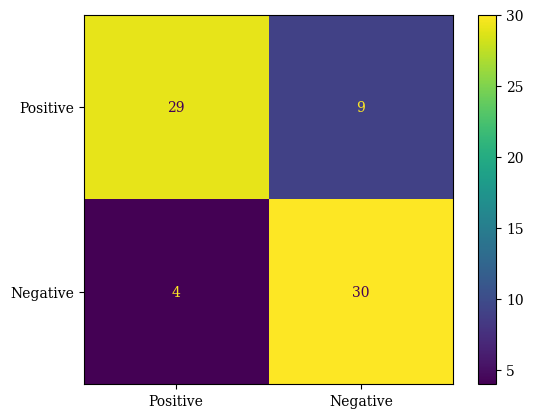

In [ ]:
# Confusion Matrix SVM
MatrizConfusao2 = confusion_matrix(targs_SVM,preds_SVM)
ConfusionMatrixDisplay(confusion_matrix(targs_SVM,preds_SVM),display_labels=['Positive','Negative']).plot()
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.xlabel('')
plt.ylabel('')
plt.plot(title="SVM")

In [ ]:
outlier_index=list(outliers.index)
print(outlier_index)

[1, 4, 6, 7, 9, 11, 13, 15, 16, 18, 20, 22, 25, 27, 29, 30, 32, 33, 35, 37, 39, 41, 43, 45, 47, 50, 54, 56, 58, 61, 62, 65, 68, 71, 72, 75, 76, 77, 81, 83, 84, 86, 87, 89, 91, 93, 95, 96, 98, 100, 102, 103, 104, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 128, 130, 133, 134, 142, 146, 148, 150, 153, 154, 156, 158, 160, 161, 162, 164, 166, 168, 170, 171, 173, 176, 177, 180, 181, 183, 187, 189, 192, 193, 196, 197, 199, 202, 203, 205, 208, 210, 211, 212, 215, 216, 218, 220, 222, 225, 226, 229, 230, 232, 233, 236, 237, 238, 240, 242, 245, 247, 249, 251, 253, 255, 258, 259, 260, 263, 264, 266, 268, 270, 271, 272, 275, 276, 277, 279, 282, 283, 286, 288, 290, 292, 294, 296, 302, 314, 316, 318, 320, 322, 324, 326, 328, 329, 331, 333, 335, 339, 341, 342, 345, 346, 348, 351, 352, 354, 356]


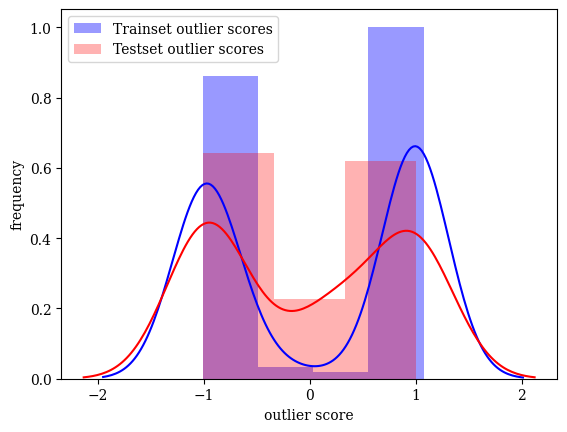

In [ ]:
outlier_scores_train = model_SVM.decision_function(train_data)
outlier_scores_test  = model_SVM.decision_function(test_data)

train_df = pd.concat([train_data.reset_index(drop=True), pd.DataFrame(outlier_scores_train, columns=["outlier score"])], axis=1)
test_df = pd.concat([test_data.reset_index(drop=True), pd.DataFrame(outlier_scores_test, columns=["outlier score"])], axis=1)

sns.distplot(outlier_scores_train, kde=True, norm_hist=True, color="b", label="Trainset outlier scores")
sns.distplot(outlier_scores_test,  kde=True, norm_hist=True, color="r", label="Testset outlier scores", hist_kws={'alpha': 0.3})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.xlabel("outlier score")
plt.ylabel("frequency")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.legend()
plt.show()

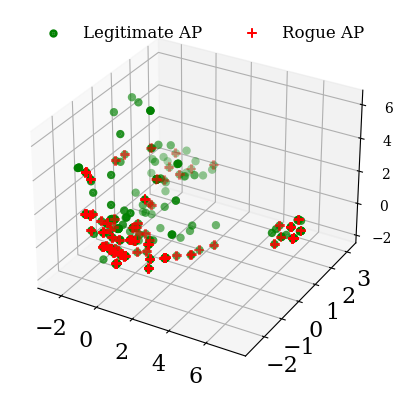

In [ ]:
# Visualization
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(data)
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=4, label="Legitimate AP",c="green")
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=7, s=4, marker="+", c="red", label="Rogue AP")
ax.legend(fontsize=12,frameon=False,ncol=2)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.yticks(size=16)
plt.xticks(size=16)
plt.tick_params(size=16)
plt.savefig("PCA3D.pdf", format="pdf", bbox_inches="tight",)
plt.show()

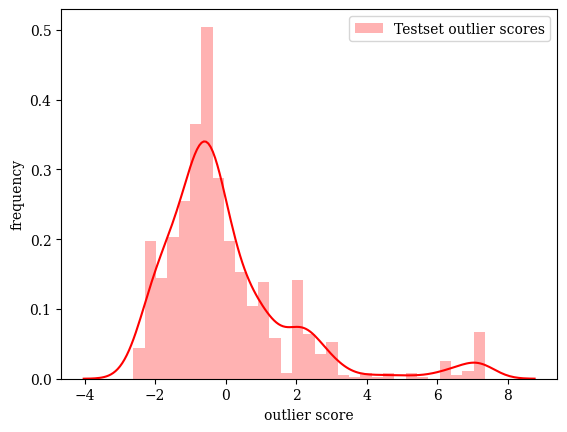

In [ ]:


sns.distplot(X_reduce,  kde=True, norm_hist=True, color="r", label="Testset outlier scores", hist_kws={'alpha': 0.3})
#sns.distplot(X_reduce[outlier_index],  kde=True, norm_hist=True, color="r", label="Testset outlier scores", hist_kws={'alpha': 0.3})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.xlabel("outlier score")
plt.ylabel("frequency")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.legend()
plt.show()

In [ ]:
#def make_meshgrid(x, y, h=.02):
#    x_min, x_max = x.min() - 1, x.max() + 1
#    y_min, y_max = y.min() - 1, y.max() + 1
#    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
#    return xx, yy

#def plot_contours(ax, clf, xx, yy, **params):
#    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
#    Z = Z.reshape(xx.shape)
#    out = ax.contourf(xx, yy, Z, **params)
#    return out

#clf = model_SVM.fit(train_data,train_target)

#fig, ax = plt.subplots()
# title for the plots
#title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
#X0, X1 = X[:, 0], X[:, 1]
#xx, yy = make_meshgrid(X0, X1)

#plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
#ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
#ax.set_ylabel('y label here')
#ax.set_xlabel('x label here')
#ax.set_xticks(())
#ax.set_yticks(())
#ax.set_title(title)
#ax.legend()
#plt.show()

In [ ]:
%%bash
# Install UMAP/hdbscan (recommend to do this before miniconda)
pip install --quiet umap-learn hdbscan


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.8 MB/s eta 0:00:00


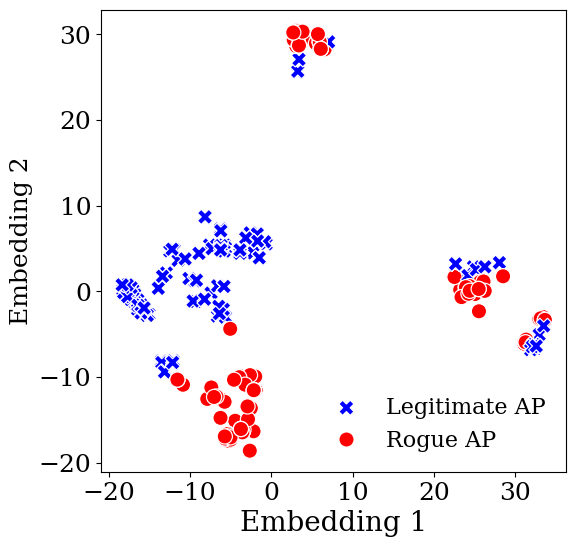

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

rogue = []
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(df_orig)
palette = sns.color_palette(["red", "blue"])
fig = plt.figure(figsize=(6,6))
sns.scatterplot(data=df_orig,
                    x=X_tsne[:,0],
                    y=X_tsne[:,1],
                    hue="rogue",
                    alpha=1.0,
                    s=120,
                    style="rogue",
                    palette=palette)
plt.legend(['Legitimate AP','Rogue AP'],markerscale=1,loc="lower right", fontsize=16,frameon=False)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.yticks(size=18)
plt.xticks(size=18)
plt.xlabel("Embedding 1", size=20)
plt.ylabel("Embedding 2", size=18)
plt.savefig("TSNE.pdf", format="pdf", bbox_inches="tight",)
plt.plot(style=['o', 'rw'])
plt.show()